In [1]:
import qutip as qp
import numpy as np
import matplotlib.pyplot as plt
import H_generator
from GFE import GFE_circuit

In [2]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

## Rand initial state

### Set parameters and initialize

In [3]:
QC = GFE_circuit()

# Hamiltonian and initial state construction
N = 4
J = 1
g = 2
shift_E = 8.6
H = H_generator.build_Ising_model(N, J, g, shift_E)
E_exact = H.eigenenergies()[0] # Exact ground state energy

dy, My = 0.08, 130 # discrete parameters
QC.set_discrete_parameters(dy, My)

In [4]:
# different noise parameter to mitigate error
c_list = np.array([1, 1.1, 1.2, 1.3, 1.4])
M = []
for i in range(len(c_list)):
    M.append(c_list**(i))
M = np.array(M)
inv_M = np.linalg.pinv(M)
one_zero_vec = np.zeros(len(c_list))
one_zero_vec[0] = 1
gamma_list = np.dot(inv_M, one_zero_vec)

### Bit-flip noise

In [5]:
# load data
num_mat, den_mat = np.load('./data/solve_ising_4_qubit_bit_flip_rand_ini.npy', allow_pickle=True)

'''
The data contains five sets of numerator list and denominator list. The first one
corresponds zero noise case, and the others correspond to different noise cases.
'''

# My list and max phase list
My_list = np.arange(30, 135, 20)
max_phase_list = My_list*0.08

# mu and sigma square list to scan
mu_list = np.arange(0, -0.5, -0.05)
inv_sig_squ_list = np.arange(1, 3, 0.3)
sig_squ_list = 1/inv_sig_squ_list

E_min_list_noiseless = [] # Estimated energy for noiseless case
E_min_list_noisy = [] # Estimated energy under noise
E_min_list_mitigated = [] # Estimated energy after noise mitigation
for My in My_list:
    QC.set_discrete_parameters(dy, My) # update My
    # energy list for single max phase
    # each energy corresponds to a Gaussian filter parameter
    E_list_noiseless = []
    E_list_noisy = []
    E_list_mitigated = []
    for sig_squ in sig_squ_list:
        for mu in mu_list:
            # Scan the Gaussian filter parameter to search the minimum energy
            QC.set_Gaussian_parameters(sig_squ, mu)
            # generate the coefficient corresponding to the different Gaussian parameters
            by_list = QC.generate_coefficient()
            E_list_c = [] # store the Energy corresponding to different noise
            for i in range(len(num_mat)):
                num_list = num_mat[i][260-2*My:261+2*My]
                den_list = den_mat[i][260-2*My:261+2*My]
                E = QC.compute_E(by_list, num_list, den_list)
                E_list_c.append(E)
            E_list_c = abs(np.array(E_list_c))
            E_list_noiseless.append(E_list_c[0])
            E_list_noisy.append(E_list_c[1])
            # the mitigated one is a weighted summation of energy for different noise case
            E_list_mitigated.append(sum(E_list_c[1:]*gamma_list))
    # append the minimum energy to list
    E_min_list_noiseless.append(min(E_list_noiseless))
    E_min_list_noisy.append(min(E_list_noisy))
    E_min_list_mitigated.append(min(E_list_mitigated))

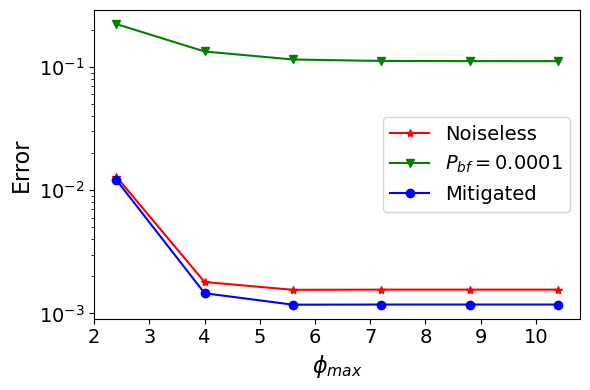

In [6]:
fig = plt.figure(figsize = [6, 4])
plt.plot(max_phase_list, abs(E_min_list_noiseless - E_exact), 'r-*', label='Noiseless')
plt.plot(max_phase_list, abs(E_min_list_noisy - E_exact), 'g-v', label='$P_{bf}=0.0001$')
plt.plot(max_phase_list, abs(E_min_list_mitigated - E_exact), 'b-o', label='Mitigated')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.xlabel('$\phi_{max}$',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.yscale('log')
plt.tight_layout()

plt.show()
fig.savefig("./figures/Ising_qubit_4_random_ini_with_bit_flip_E_vs_max_phase", dpi = 300, bbox_inches = 'tight')

In [7]:
E_min_list_noiseless - E_exact

array([0.01291529, 0.00179655, 0.00155315, 0.00155785, 0.00155784,
       0.00155784])

In [8]:
E_min_list_noisy - E_exact

array([0.22351555, 0.13378496, 0.11517172, 0.11208723, 0.1117118 ,
       0.11168082])

In [9]:
E_min_list_mitigated - E_exact

array([0.01215422, 0.00145742, 0.00117591, 0.00117923, 0.00117919,
       0.00117919])

### Phase-flip noise

In [10]:
# load data
num_mat, den_mat = np.load('./data/solve_ising_4_qubit_phase_flip_rand_ini.npy', allow_pickle=True)

My_list = np.arange(30, 135, 20)
max_phase_list = My_list*0.08

# mu and sigma square list to scan
mu_list = np.arange(0, -0.5, -0.05)
inv_sig_squ_list = np.arange(1, 3, 0.3)
sig_squ_list = 1/inv_sig_squ_list

E_min_list_noiseless = []
E_min_list_noisy = []
E_min_list_mitigated = []
for My in My_list:
    QC.set_discrete_parameters(dy, My)
    E_list_noiseless = []
    E_list_noisy = []
    E_list_mitigated = []
    for sig_squ in sig_squ_list:
        for mu in mu_list:
            QC.set_Gaussian_parameters(sig_squ, mu)
            by_list = QC.generate_coefficient()
            E_list_c = []
            for i in range(len(num_mat)):
                num_list = num_mat[i][260-2*My:261+2*My]
                den_list = den_mat[i][260-2*My:261+2*My]
                E = QC.compute_E(by_list, num_list, den_list)
                E_list_c.append(E)
            E_list_c = abs(np.array(E_list_c))
            E_list_noiseless.append(E_list_c[0])
            E_list_noisy.append(E_list_c[1])
            E_list_mitigated.append(sum(E_list_c[1:]*gamma_list))
    E_min_list_noiseless.append(min(E_list_noiseless))
    E_min_list_noisy.append(min(E_list_noisy))
    E_min_list_mitigated.append(min(E_list_mitigated))

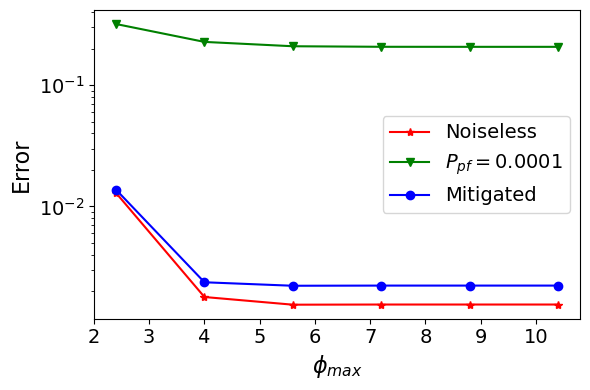

In [11]:
fig = plt.figure(figsize = [6, 4])
plt.plot(max_phase_list, abs(E_min_list_noiseless - E_exact), 'r-*', label='Noiseless')
plt.plot(max_phase_list, abs(E_min_list_noisy - E_exact), 'g-v', label='$P_{pf}=0.0001$')
plt.plot(max_phase_list, abs(E_min_list_mitigated - E_exact), 'b-o', label='Mitigated')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.xlabel('$\phi_{max}$',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.yscale('log')
plt.tight_layout()

plt.show()
fig.savefig("./figures/Ising_qubit_4_random_ini_with_phase_flip_E_vs_max_phase", dpi = 300, bbox_inches = 'tight')

In [12]:
E_min_list_noiseless - E_exact

array([0.01291529, 0.00179655, 0.00155315, 0.00155785, 0.00155784,
       0.00155784])

In [13]:
E_min_list_noisy - E_exact

array([0.31824267, 0.22676715, 0.20882317, 0.20668381, 0.2065216 ,
       0.20651396])

In [14]:
E_min_list_mitigated - E_exact

array([0.01373394, 0.00237621, 0.00222423, 0.00223125, 0.00223125,
       0.00223125])

## Well-prepared initial state
In above procedure, we adopt a random generalized initial state. If we can prepare the initial state with the knowledge of the Hamiltonian, the result may be better. For example, in this demonstration, the $\sum_{n} \sigma^{x}_{n}$ term is the leading term. We may prepare an initial state that is the eigenstate of $\sum_{n} \sigma^{x}_{n}$ by applying a Hadmadard gate and sigima Z on each qubit.

In [15]:
# load data
num_mat, den_mat = np.load('./data/solve_ising_4_qubit_bit_flip_well_prep_ini.npy', allow_pickle=True)

My_list = np.arange(30, 135, 20)
max_phase_list = My_list*0.08

# mu and sigma square list to scan
mu_list = np.arange(0, -0.5, -0.05)
inv_sig_squ_list = np.arange(1, 3, 0.3)
sig_squ_list = 1/inv_sig_squ_list

E_min_list_noiseless = []
E_min_list_noisy = []
E_min_list_mitigated = []
for My in My_list:
    QC.set_discrete_parameters(dy, My)
    E_list_noiseless = []
    E_list_noisy = []
    E_list_mitigated = []
    for sig_squ in sig_squ_list:
        for mu in mu_list:
            QC.set_Gaussian_parameters(sig_squ, mu)
            by_list = QC.generate_coefficient()
            E_list_c = []
            for i in range(len(num_mat)):
                num_list = num_mat[i][260-2*My:261+2*My]
                den_list = den_mat[i][260-2*My:261+2*My]
                E = QC.compute_E(by_list, num_list, den_list)
                E_list_c.append(E)
            E_list_c = abs(np.array(E_list_c))
            E_list_noiseless.append(E_list_c[0])
            E_list_noisy.append(E_list_c[1])
            E_list_mitigated.append(sum(E_list_c[1:]*gamma_list))
    E_min_list_noiseless.append(min(E_list_noiseless))
    E_min_list_noisy.append(min(E_list_noisy))
    E_min_list_mitigated.append(min(E_list_mitigated))

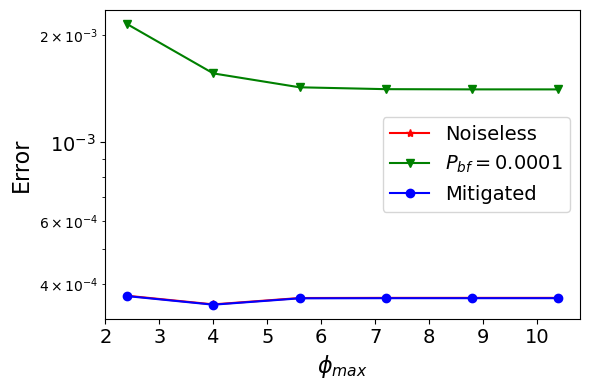

In [16]:
fig = plt.figure(figsize = [6, 4])
plt.plot(max_phase_list, abs(E_min_list_noiseless - E_exact), 'r-*', label='Noiseless')
plt.plot(max_phase_list, abs(E_min_list_noisy - E_exact), 'g-v', label='$P_{bf}=0.0001$')
plt.plot(max_phase_list, abs(E_min_list_mitigated - E_exact), 'b-o', label='Mitigated')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.xlabel('$\phi_{max}$',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.yscale('log')
plt.tight_layout()

plt.show()
fig.savefig("./figures/Ising_qubit_4_well_prep_ini_with_bit_flip_E_vs_max_phase", dpi = 300, bbox_inches = 'tight')

In [17]:
E_min_list_noiseless - E_exact

array([0.00037002, 0.00034982, 0.00036457, 0.00036491, 0.00036491,
       0.00036491])

In [18]:
E_min_list_noisy - E_exact

array([0.00215324, 0.00156352, 0.00142888, 0.00141168, 0.00140972,
       0.00140955])

In [19]:
E_min_list_mitigated - E_exact

array([0.00036917, 0.00034914, 0.00036384, 0.00036418, 0.00036418,
       0.00036418])

### Phase-flip noise

In [20]:
# load data
num_mat, den_mat = np.load('./data/solve_ising_4_qubit_phase_flip_well_prep_ini.npy', allow_pickle=True)

My_list = np.arange(30, 135, 20)
max_phase_list = My_list*0.08

# mu and sigma square list to scan
mu_list = np.arange(0, -0.5, -0.05)
inv_sig_squ_list = np.arange(1, 3, 0.3)
sig_squ_list = 1/inv_sig_squ_list

E_min_list_noiseless = []
E_min_list_noisy = []
E_min_list_mitigated = []
for My in My_list:
    QC.set_discrete_parameters(dy, My)
    E_list_noiseless = []
    E_list_noisy = []
    E_list_mitigated = []
    for sig_squ in sig_squ_list:
        for mu in mu_list:
            QC.set_Gaussian_parameters(sig_squ, mu)
            by_list = QC.generate_coefficient()
            E_list_c = []
            for i in range(len(num_mat)):
                num_list = num_mat[i][260-2*My:261+2*My]
                den_list = den_mat[i][260-2*My:261+2*My]
                E = QC.compute_E(by_list, num_list, den_list)
                E_list_c.append(E)
            E_list_c = abs(np.array(E_list_c))
            E_list_noiseless.append(E_list_c[0])
            E_list_noisy.append(E_list_c[1])
            E_list_mitigated.append(sum(E_list_c[1:]*gamma_list))
    E_min_list_noiseless.append(min(E_list_noiseless))
    E_min_list_noisy.append(min(E_list_noisy))
    E_min_list_mitigated.append(min(E_list_mitigated))

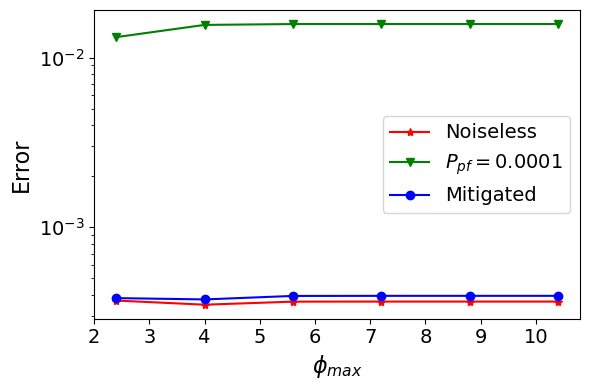

In [21]:
fig = plt.figure(figsize = [6, 4])
plt.plot(max_phase_list, abs(E_min_list_noiseless - E_exact), 'r-*', label='Noiseless')
plt.plot(max_phase_list, abs(E_min_list_noisy - E_exact), 'g-v', label='$P_{pf}=0.0001$')
plt.plot(max_phase_list, abs(E_min_list_mitigated - E_exact), 'b-o', label='Mitigated')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.xlabel('$\phi_{max}$',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.yscale('log')
plt.tight_layout()

plt.show()
fig.savefig("./figures/Ising_qubit_4_well_prep_ini_with_phase_flip_E_vs_max_phase", dpi = 300, bbox_inches = 'tight')

In [22]:
E_min_list_noiseless - E_exact

array([0.00037002, 0.00034982, 0.00036457, 0.00036491, 0.00036491,
       0.00036491])

In [23]:
E_min_list_noisy - E_exact

array([0.01322494, 0.01561072, 0.01579404, 0.01579727, 0.01579728,
       0.01579728])

In [24]:
E_min_list_mitigated - E_exact

array([0.00038252, 0.00037576, 0.00039396, 0.0003945 , 0.0003945 ,
       0.0003945 ])